References: Tutorials and code that were/was used and referenced in the making of this project can be found at the following links: https://www.youtube.com/watch?v=tPYj3fFJGjk&t=16670s and https://www.youtube.com/watch?v=44U8jJxaNp8

Imports

In [1]:
%tensorflow_version 2.x 

import tensorflow as tf

from tensorflow.keras import layers, models

import numpy as np

import matplotlib.pyplot as plt

keras = tf.keras

from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image

import os

import random

Loading the data into train and test sets

In [2]:
os.chdir('/content/drive/MyDrive/ProjectExtras/Weather')

In [ ]:
raw_train_images = []
x = 0
for element in os.listdir():
    raw_train_images.append(image.load_img(element, target_size=(224,224)))
    print(x)
    x += 1

About the dataset: This dataset was found online, and it classifies images of outdoor scenes based on the weather. The dataset has images that each can be classified by 1 of 4 different labels: cloudy, rain, shine, or sunrise (although "sunrise" isn't usually referred to as weather, we kept it in there becasue that's the label the dataset used)

Converting each image into a numpy array

In [4]:
for index, value in enumerate(raw_train_images):
    raw_train_images[index] = np.array(value)

Making the entire set of images a numpy array of numpy arrays

In [5]:
all_images = np.array(raw_train_images)

In [ ]:
all_images.shape

Saving the image array

In [ ]:
np.save('/content/drive/MyDrive/ProjectExtras/WeatherArray.npy', all_images)

Creating the labels array

In [7]:
# cloudy = 0
# rain = 1
# shine = 2
# sunrise = 3
all_labels = []
for element in os.listdir():
    if 'cloudy' in element.lower():
        all_labels.append(0)
    elif 'rain' in element.lower():
        all_labels.append(1)
    elif 'shine' in element.lower():
        all_labels.append(2)
    else:
        all_labels.append(3)


Associating each image with its correspoding label with a tuple. This will allow the dataset to be shuffled without losing image/label correspondance

In [8]:
tuple_array = []
for index, value in enumerate(all_images):
    tuple_array.append((all_images[index], all_labels[index]))

Shuffling the data set

In [9]:
random.shuffle(tuple_array)

Splitting the data set into test and train subsets

In [10]:
weather_train_images = []
weather_test_images = []
weather_test_labels = []
weather_train_labels = []

for index, value in enumerate(tuple_array[0:900]):
    weather_train_images.append(value[0])
    weather_train_labels.append(value[1])

for index, value in enumerate(tuple_array[901:]):
    weather_test_images.append(value[0])
    weather_test_labels.append(value[1])


turning lists into numpy arrays

In [11]:
weather_test_images = np.array(weather_test_images)
weather_train_images = np.array(weather_train_images)

Function that will make the pixel values between 0 and 1 rather than between 0 and 255

In [12]:
def format_images(images):
  images = images.astype('float32')
  images = images/255
  return images

Using the above function to format the images

In [ ]:
format_images(weather_test_images)

In [ ]:
format_images(weather_train_images)

making the label lists into numpy arrays

In [15]:
weather_test_labels = np.array(weather_test_labels)
weather_train_labels = np.array(weather_train_labels)

Converting the numpy arrays into tensors for faster computing

In [16]:
weather_train_images = tf.convert_to_tensor(weather_train_images)
weather_test_images = tf.convert_to_tensor(weather_test_images)
weather_train_labels = tf.convert_to_tensor(weather_train_labels)
weather_test_labels = tf.convert_to_tensor(weather_test_labels)

Using a pre-trained model for the convolutional base layers

In [17]:
# using MobileNetV2
pretrained_base = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                               # include_top is false because we want to create our own
                                               # classifier at the end of the NN. We just want to use
                                               # the pre-trained convolutional layers, not the entire pre-trained NN.
                                               include_top=False, weights='imagenet')

Making the base model untrainable

In [18]:
# we don't want to retrain the convolutional layers that were already trained for us
pretrained_base.trainable = False

Average Pooling layer

In [19]:
# Utilizes average pooling to flatten the output of the convolutional layer. Because this layer is a pooling layer, it does not strictly
# flatten the output; it also strinks overall size of the output due to the average pooling. The flattening yields a feature vector that can
# be passed into the prediction/dense layer.
flattening_layer = tf.keras.layers.GlobalAveragePooling2D()

Dense Layer (this is the final layer and will give us our predictions)

In [20]:
# this will be the final layer in the entire NN. It will classify images as one of the four weather categories. It has 4 neurons because there
# are 4 different label options
prediction_layer = keras.layers.Dense(4)

Putting all the layers together to form the complete sequential model

In [21]:
# putting all the layers together to form the complete sequential model
model = tf.keras.Sequential([pretrained_base, flattening_layer, prediction_layer])

Summary of the complete model

In [ ]:
model.summary()

Compiling our model

In [22]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

Training the model

In [23]:
# Now we can train it on our images
history = model.fit(weather_train_images, weather_train_labels, epochs=4, batch_size=16)
print(history.history['accuracy'])

Epoch 1/4
57/57 [==============================] - 8s 64ms/step - loss: 0.9833 - accuracy: 0.5711
Epoch 2/4
57/57 [==============================] - 3s 58ms/step - loss: 0.6164 - accuracy: 0.7722
Epoch 3/4
57/57 [==============================] - 3s 59ms/step - loss: 0.5120 - accuracy: 0.8033
Epoch 4/4
57/57 [==============================] - 3s 58ms/step - loss: 0.4439 - accuracy: 0.8311
[0.5711110830307007, 0.7722222208976746, 0.8033333420753479, 0.8311111330986023]


Testing the accuracy of our model on our test dataset

In [24]:
model.evaluate(weather_test_images, weather_test_labels)

7/7 [==============================] - 2s 100ms/step - loss: 0.5227 - accuracy: 0.8214


[0.5226592421531677, 0.8214285969734192]

This function translates the prediction array into a string that says either "cloudy," "rain," "shine," or "sunrise"

In [25]:
def evaluate_prediction(prediction):
    max_index = 0
    max_val = prediction[0][0]
    for index, value in enumerate(prediction[0]):
        if value > max_val:
            max_index = index
            max_val = value
    if max_index == 0:
        return "Cloudy"
    elif max_index == 1:
        return "Rain"
    elif max_index == 2:
        return "Shine"
    else:
        return "Sunrise"


This function takes in an image from the test data set, then shows a plot of the image and the prediction that the model made for it

In [26]:
def predict_an_image(image):
    my_test_image = np.expand_dims(image, axis=0)
    my_prediction = model.predict(my_test_image)
    plt.imshow(image)
    plt.title("Prediction: " + evaluate_prediction(my_prediction))
    

Seeing the model's predictions for images in the test data set

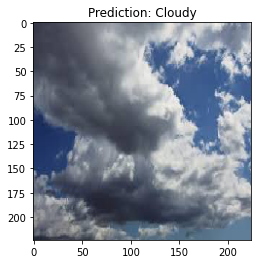

In [29]:
# k can be set to anything the user desires. It is simply used to select an image from the test dataset, display it, and show the user the
# model's prediction for it
k = 122
predict_an_image(weather_test_images[k])

Importing our own image

In [30]:
imported_img = image.load_img('/content/drive/MyDrive/ProjectExtras/MC-5-3-20-Sunrise-01.jpg', target_size=(224, 224))

This function takes in an imported image, then shows a plot of the image and the prediction that the model made for it

In [31]:
def predict_imported_image(imported_img):
    img_array = image.img_to_array(imported_img)
    my_formatted_image = format_images(img_array)
    img_batch = np.expand_dims(my_formatted_image, axis=0)
    img_preprocessed = preprocess_input(img_batch)
    our_prediction = model.predict(img_batch)
    # showing output
    plt.imshow(imported_img)
    plt.title("Prediction: " + evaluate_prediction(our_prediction))

Showing predictions made for various imported images

***NOTE*** We are aware that "Sunrise" is not usually referred to as a
weather category, however, this dataset used it as one of its labels.


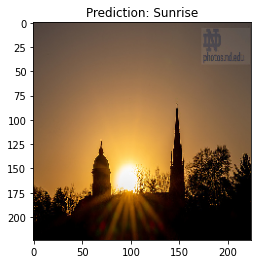

In [32]:
predict_imported_image(np.rot90(imported_img, k=4))
print("***NOTE*** We are aware that \"Sunrise\" is not usually referred to as a\nweather category, however, this dataset used it as one of its labels.")

Saving our model

In [ ]:
model.save("WeatherPrediction.h5")  # we can save the model and reload it at anytime in the future
new_model = tf.keras.models.load_model('WeatherPrediction.h5')